In [1]:
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import sys
from scipy.interpolate import griddata
from tqdm import tqdm
# sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
sys.path.append('/home/jiarong/research/postprocessing/functions/')
from Amplitude import Amplitude
from fio import readin

In [6]:
from matplotlib import rc
from matplotlib.ticker import FormatStrFormatter
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
common_path = '/home/jiarong/research/projects/windwave/'
para_name = ['Ustar','ak','Bo','Re','LEVEL']

Some figures:  
$\sigma = \frac{1}{k^2 \times BO}$   
$\omega^2 = gk(1+\frac{\sigma k^2}{\rho_w g})= gk(1+1/BO) = gk(1+1/3.45)$  
$\omega = 2.846$  
$c = \omega / k = 0.4532$  
Orbital velocity from gravity wave $Ux_{max} = \frac{ag}{\omega}k = (ak)g/\omega = (ak)*0.0176$  
The time period in the original code is computed by $\omega^2 = gk$, which is a significant deviation.

In [ ]:
# It's the iterator's job to assemble the filename and read
def iter_onecase(postfix_index_set, tag_set, tag_common):
    '''
    postfix_index_set: list of numbers
        A list of corresponding indices used to distinguish the cases.
    tag_set: list of strings
        A list of tags that distinguish each case, can be different from the index set 
    
    '''

    # Instantiate amplitude as a list
    amplitude = []
    
    for i,(index,tag) in enumerate(zip(postfix_index_set, tag_set)):   
        # Use the enhanced read-in function   
        # Rewrite the line according to the file naming 
        # filename = 'filename_common' + '%g' %postfix_index + file_format
        filename = './eta' + '%g' %index
        # Rewrite this line according to the delimiter and the fields attributes
        eta = readin(filename, table_delimiter = ',')
        eta.rename(columns={'pos':'eta'}, inplace=True)
        # Instantiate a amplitude class member
        ampl = Amplitude(eta[['x', 'eta', 'f']])
        amplitude.append(ampl)
        ampl.plot_amplitude(ax, color_choice=plt.cm.get_cmap('summer')(color_idx[i]), label_choice=tag_common+tag)
        # A mark line on crest position if necessary
    #         crest = np.array(eta[eta['pos']==eta['pos'].max()].x)
    #         x_crest = np.average(crest)
    #         x = x_crest*np.ones(100)
    #         y = np.linspace(0, 0.02, 100, endpoint=True)
    #         plt.plot(x, y, color=plt.cm.get_cmap('summer')(color_idx[(i+1)//delta]))

    # def amplitude(eta):
    return amplitude



In [3]:
# A function that iterate through one single process
def iter_onecase(postfix_index_set, tag_set, tag_common):
    '''
    postfix_index_set: list of numbers
        A list of corresponding indices used to distinguish the cases.
    tag_set: list of strings
        A list of tags that distinguish each case, can be different from the index set 
    
    '''

    # Instantiate amplitude as a list
    amplitude = []
    
    for i,(index,tag) in enumerate(zip(postfix_index_set, tag_set)):   
        # Use the enhanced read-in function   
        # Rewrite the line according to the file naming 
        # filename = 'filename_common' + '%g' %postfix_index + file_format
        filename = './eta' + '%g' %index
        # Rewrite this line according to the delimiter and the fields attributes
        eta, exists = readin(filename, table_delimiter = ',')
        if exists:
            eta.rename(columns={'pos':'eta'}, inplace=True)
            # Instantiate a amplitude class member
            ampl = Amplitude(eta[['x', 'eta', 'f']])
            amplitude.append(ampl)
    return amplitude, exists


# A function wrapping around iter_onecase to iterate over several cases
def iter_para_oldversion(para_pair_set, para_name, common_path, postfix_index, tag):
    amplitude_set = []
    energydirect_set = []
    for p in tqdm(para_pair_set):
        # Assemble the directory name corresponding to each parameter set
        # Example: dirname = './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10'
        dirname = 'linear_m5B0'
        for i,name in enumerate(para_name):
            if name == 'Re':
                dirname += name + '%g' %p[i] + '.'
            else:
                dirname += name + '%g' %p[i]  
        # Change path 
        os.chdir(common_path + dirname)
        # Call iter_onecase, pass directory name as a parameter
        amplitude, exists = iter_onecase(postfix_index_set=postfix_index, tag_set=tag, tag_common = 't = ')
        # If the file does not exceed, do not append
        if exists:
            amplitude_set.append(amplitude)
        energy, exists = readin('budgetWaterwind.dat', table_delimiter = ' ', skipn = 100)
        if exists:
            total = energy.ke/2 + energy.gpe
            diss = np.zeros(energy.shape[0])
            for i, row in energy.iterrows():
                if i == 0:
                    diss[i] = 0
                    last_t = row['t'] # record t in last row
                else:
                    diss[i] = diss[i-1] + row['dissipation'] * (row['t'] - last_t)
                    last_t = row['t']
            energy.insert(len(energy.columns), "total", total, True)
            energy.insert(len(energy.columns), "total_diss", total+diss, True)
            energydirect_set.append(energy)       
    return amplitude_set, energydirect_set


In [ ]:
import pickle
os.chdir('/home/jiarong/research/projects/windwave/common')
picklename = 'ensemble'
outfile = open(picklename,'wb')
# Need to change the actual u*/c before pickle
para_pair_set = [[0.4,0.05,3.45,31000,10], [0.45,0.05,3.45,31000,10], [0.5,0.05,3.45,31000,10], [0.55,0.05,3.45,31000,10], 
                 [0.6,0.05,3.45,31000,10], [0.5,0.01,3.45,31000,11], [0.5,0.02,3.45,31000,10], [0.5,0.03,3.45,31000,10],
                 [0.5,0.04,3.45,31000,10], [0.5,0.06,3.45,31000,10], [0.5,0.1,3.45,31000,10], [0.5,0.15,3.45,31000,10],
                 [0.5,0.2,3.45,31000,10], [0.5,0.05,10,31000,10], [0.5,0.05,50,31000,10], [0.5,0.05,1,31000,10], 
                 [0.5,0.05,0.49,31000,10], [0.5,0.05,3.45,20000,10], [0.5,0.05,3.45,40000,10], [0.5,0.05,3.45,50000,10]]
for para in para_pair_set:
    para[0] = para[0]/(1+1/para[2])**0.5
# Pickle
data = (para_name, common_path, postfix_index, tag, para_pair_set, ampl_set, edirect_set)
pickle.dump(data,outfile)

# Load pickled cases
(para_name, common_path, postfix_index, tag, para_pair_set, ampl_set, edirect_set) = pickle.load( open( "ensemble", "rb" ) )
# Add new cases
para_pair_append = [[0.396, 0.05, 0.53, 31000, 10], [0.44, 0.05, 0.53, 31000, 10], [0.484, 0.05, 0.53, 31000, 10], 
                    [0.528, 0.05, 0.53, 31000, 10], [0.572, 0.05, 0.53, 31000, 10], [0.616, 0.05, 0.53, 31000, 10],
                    [0.66, 0.05, 0.53, 31000, 10]
# Run with new version (kinetic energy change)
ampl_append, edirect_append = iter_para_newversion(para_pair_append, para_name, common_path, postfix_index, tag)
for para, ampl, edirect in zip(para_pair_append, ampl_append, edirect_append):
    para_pair_set.append(para)
    ampl_set.append(ampl)
    edirect_set.append(edirect)
picklename = 'ensemble'
outfile = open(picklename,'wb')
data = (para_name, common_path, postfix_index, tag, para_pair_set, ampl_set, edirect_set)
pickle.dump(data,outfile)

In [4]:
# Define a new function because of the new kinetic energy book keeping
def iter_para_newversion(para_pair_set, para_name, common_path, postfix_index, tag):
    amplitude_set = []
    energydirect_set = []
    for p in tqdm(para_pair_set):
        # Assemble the directory name corresponding to each parameter set
        # Example: dirname = './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10'
        dirname = 'linear_m5B0'
        for i,name in enumerate(para_name):
            if name == 'Re':
                dirname += name + '%g' %p[i] + '.'
            else:
                dirname += name + '%g' %p[i]  
        # Change path 
        os.chdir(common_path + dirname)
        # Call iter_onecase, pass directory name as a parameter
        amplitude, exists = iter_onecase(postfix_index_set=postfix_index, tag_set=tag, tag_common = 't = ')
        # If the file does not exceed, do not append
        if exists:
            amplitude_set.append(amplitude)
        energy, exists = readin('budgetWaterwind.dat', table_delimiter = ' ', skipn = 100)
        if exists:
            # HERE IS THE DIFFERENCE! 
            # total = energy.ke/2 + energy.gpe
            total = energy.ke + energy.gpe
            diss = np.zeros(energy.shape[0])
            for i, row in energy.iterrows():
                if i == 0:
                    diss[i] = 0
                    last_t = row['t'] # record t in last row
                else:
                    diss[i] = diss[i-1] + row['dissipation'] * (row['t'] - last_t)
                    last_t = row['t']
            energy.insert(len(energy.columns), "total", total, True)
            energy.insert(len(energy.columns), "total_diss", total+diss, True)
            energydirect_set.append(energy)       
    return amplitude_set, energydirect_set



In [ ]:
# Anything above 0.616 does not seem to give growth
(para_name, common_path, postfix_index, tag, para_pair_set, ampl_set, edirect_set) = pickle.load( open( "ensemble", "rb" ) )
# Add new cases
para_pair_append = [[0.616, 0.05, 0.36, 31000., 10], [0.616, 0.05, 0.83, 31000., 10], [0.616, 0.05, 1.47, 31000., 10], 
                    [0.616, 0.05, 3.31, 31000., 10], [0.66, 0.05, 0.36, 31000., 10], [0.66, 0.05, 0.83, 31000., 10],
                    [0.66, 0.05, 1.47, 31000., 10], [0.66, 0.05, 3.31, 31000., 10]]
# Run with new version (kinetic energy change)
ampl_append, edirect_append = iter_para_newversion(para_pair_append, para_name, common_path, postfix_index, tag)
for para, ampl, edirect in zip(para_pair_append, ampl_append, edirect_append):
    para_pair_set.append(para)
    ampl_set.append(ampl)
    edirect_set.append(edirect)
picklename = 'ensemble'
outfile = open(picklename,'wb')
data = (para_name, common_path, postfix_index, tag, para_pair_set, ampl_set, edirect_set)
pickle.dump(data,outfile)

In [23]:
para_pair_set, ampl_set, edirect_set = [], [], []
postfix_index = np.arange(0, 1.5, 0.03125)
tag = np.char.mod('%d', postfix_index)
# Add new cases
para_pair_append = [[0.44, 0.05, 0.16, 31000., 10],[0.44, 0.05, 0.36, 31000., 10],[0.44, 0.05, 0.53, 31000., 10],[0.44, 0.05, 0.83, 31000., 10], 
                    [0.44, 0.05, 1.47, 31000., 10],[0.44, 0.05, 3.31, 31000., 10],
                    [0.484, 0.05, 0.16, 31000., 10],[0.484, 0.05, 0.36, 31000., 10],[0.484, 0.05, 0.53, 31000., 10],[0.484, 0.05, 0.83, 31000., 10],
                    [0.484, 0.05, 1.47, 31000., 10],[0.484, 0.05, 3.31, 31000., 10],
                    [0.5, 0.05, 0.16, 31000., 10],[0.5, 0.05, 0.36, 31000., 10],[0.5, 0.05, 0.53, 31000., 10],[0.5, 0.05, 0.83, 31000., 10],
                    [0.5, 0.05, 1.47, 31000., 10],[0.5, 0.05, 3.31, 31000., 10],
                    [0.528, 0.05, 0.16, 31000., 10],[0.528, 0.05, 0.36, 31000., 10],[0.528, 0.05, 0.53, 31000., 10],[0.528, 0.05, 0.83, 31000., 10],
                    [0.528, 0.05, 1.47, 31000., 10],[0.528, 0.05, 3.31, 31000., 10],
                    [0.572, 0.05, 0.16, 31000., 10],[0.572, 0.05, 0.36, 31000., 10],[0.572, 0.05, 0.53, 31000., 10],[0.572, 0.05, 0.83, 31000., 10],
                    [0.572, 0.05, 1.47, 31000., 10],[0.572, 0.05, 3.31, 31000., 10],
                    [0.6, 0.05, 0.16, 31000., 10],[0.6, 0.05, 0.36, 31000., 10],[0.6, 0.05, 0.53, 31000., 10],[0.6, 0.05, 0.83, 31000., 10],
                    [0.6, 0.05, 1.47, 31000., 10],[0.6, 0.05, 3.31, 31000., 10],
                    [0.616, 0.05, 0.36, 31000., 10],[0.616, 0.05, 0.53, 31000., 10], [0.616, 0.05, 0.83, 31000., 10],
                    [0.616, 0.05, 1.47, 31000., 10],[0.616, 0.05, 3.31, 31000., 10],
                    [0.6, 0.05, 3.31, 31000., 11],[0.6, 0.05, 1.47, 31000., 11],[0.572, 0.05, 0.16, 31000., 11], [0.572, 0.05, 0.36, 31000., 11],
                    [0.572, 0.05, 0.53, 31000., 11], [0.572, 0.05, 0.83, 31000., 11], [0.528, 0.05, 0.36, 31000., 11], [0.528, 0.05, 0.53, 31000., 11]]

# Run with new version (kinetic energy change)
ampl_append, edirect_append = iter_para_newversion(para_pair_append, para_name, common_path, postfix_index, tag)
for para, ampl, edirect in zip(para_pair_append, ampl_append, edirect_append):
    para_pair_set.append(para)
    ampl_set.append(ampl)
    edirect_set.append(edirect)
# picklename = 'ensemble'
# outfile = open(picklename,'wb')
# data = (para_name, common_path, postfix_index, tag, para_pair_set, ampl_set, edirect_set)
# pickle.dump(data,outfile)

100%|██████████| 49/49 [00:30<00:00,  1.62it/s]


In [24]:
for i, para in enumerate(para_pair_set):
    print(i, para)

0 [0.44, 0.05, 0.16, 31000.0, 10]
1 [0.44, 0.05, 0.36, 31000.0, 10]
2 [0.44, 0.05, 0.53, 31000.0, 10]
3 [0.44, 0.05, 0.83, 31000.0, 10]
4 [0.44, 0.05, 1.47, 31000.0, 10]
5 [0.44, 0.05, 3.31, 31000.0, 10]
6 [0.484, 0.05, 0.16, 31000.0, 10]
7 [0.484, 0.05, 0.36, 31000.0, 10]
8 [0.484, 0.05, 0.53, 31000.0, 10]
9 [0.484, 0.05, 0.83, 31000.0, 10]
10 [0.484, 0.05, 1.47, 31000.0, 10]
11 [0.484, 0.05, 3.31, 31000.0, 10]
12 [0.5, 0.05, 0.16, 31000.0, 10]
13 [0.5, 0.05, 0.36, 31000.0, 10]
14 [0.5, 0.05, 0.53, 31000.0, 10]
15 [0.5, 0.05, 0.83, 31000.0, 10]
16 [0.5, 0.05, 1.47, 31000.0, 10]
17 [0.5, 0.05, 3.31, 31000.0, 10]
18 [0.528, 0.05, 0.16, 31000.0, 10]
19 [0.528, 0.05, 0.36, 31000.0, 10]
20 [0.528, 0.05, 0.53, 31000.0, 10]
21 [0.528, 0.05, 0.83, 31000.0, 10]
22 [0.528, 0.05, 1.47, 31000.0, 10]
23 [0.528, 0.05, 3.31, 31000.0, 10]
24 [0.572, 0.05, 0.16, 31000.0, 10]
25 [0.572, 0.05, 0.36, 31000.0, 10]
26 [0.572, 0.05, 0.53, 31000.0, 10]
27 [0.572, 0.05, 0.83, 31000.0, 10]
28 [0.572, 0.05, 1.4

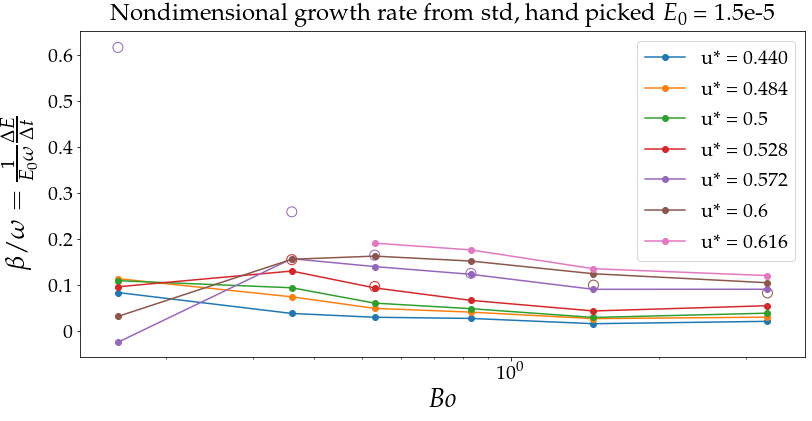

In [26]:
fig = plt.figure(figsize = (13, 6))

ax2 = fig.gca()
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax2.tick_params(axis='both', which='major', labelsize=14)
# Fit a linear growth to the lines
para_tag = np.char.mod('%d', para_pair_set[0])
# Time was scaled!!!
time = postfix_index * (2*np.pi)**0.5
Bo = []
period = []
slope_std = []
beta_std = []
nondim_beta_std = []
colors = []

def plot(ampl_subset, para_pair_subset, edirect_subset, ustartag):
    Bo = []
    period = []
    slope_std = []
    beta_std = []
    nondim_beta_std = []
    for i, (amplitude, para, energy) in enumerate(zip(ampl_subset, para_pair_subset, edirect_subset)):
        y = [ampl.stdev**2/2 for ampl in amplitude]
        a, b = np.polyfit(time, y, 1)
        slope_std.append(a)
        beta_std.append(a/1.5e-5)
        nondim_beta_std.append(a/b/(2*np.pi*(1+1/para[2]))**0.5)
        Bo.append(para[2])
        period.append((2*np.pi)**0.5/(1+1/para[2])**0.5)

    # ax2.plot(Bo, np.array(beta_std), '.', markersize=14, label = 'u* = 0.440')
    line, = ax2.plot(Bo, np.array(nondim_beta_std), marker = 'o',  label = 'u* = '+ustartag)
    colors.append(line.get_color())
    ax2.set_xlabel(r'$Bo$', fontsize = 26)
    ax2.set_ylabel(r'$\beta/\omega = \frac{1}{E_{0}\omega}\frac{\Delta E}{\Delta t}$', fontsize = 26)
    ax2.legend(fontsize = 20, loc = 'upper right')
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(20) 

ilist = [0,1,2,3,4,5]
ampl_subset = list(ampl_set[i] for i in ilist)  
para_pair_subset = list(para_pair_set[i] for i in ilist)
edirect_subset = list(edirect_set[i] for i in ilist)
plot(ampl_subset, para_pair_subset, edirect_subset, '0.440')
ilist = [6,7,8,9,10,11]
ampl_subset = list(ampl_set[i] for i in ilist)  
para_pair_subset = list(para_pair_set[i] for i in ilist)
edirect_subset = list(edirect_set[i] for i in ilist)
plot(ampl_subset, para_pair_subset, edirect_subset, '0.484')
ilist = [12,13,14,15,16,17]
ampl_subset = list(ampl_set[i] for i in ilist)  
para_pair_subset = list(para_pair_set[i] for i in ilist)
edirect_subset = list(edirect_set[i] for i in ilist)
plot(ampl_subset, para_pair_subset, edirect_subset, '0.5')
ilist = [18,19,20,21,22,23]
ampl_subset = list(ampl_set[i] for i in ilist)  
para_pair_subset = list(para_pair_set[i] for i in ilist)
edirect_subset = list(edirect_set[i] for i in ilist)
plot(ampl_subset, para_pair_subset, edirect_subset, '0.528')
ilist = [24,25,26,27,28,29]
ampl_subset = list(ampl_set[i] for i in ilist)  
para_pair_subset = list(para_pair_set[i] for i in ilist)
edirect_subset = list(edirect_set[i] for i in ilist)
plot(ampl_subset, para_pair_subset, edirect_subset, '0.572')
ilist = [30,31,32,33,34,35]
ampl_subset = list(ampl_set[i] for i in ilist)  
para_pair_subset = list(para_pair_set[i] for i in ilist)
edirect_subset = list(edirect_set[i] for i in ilist)
plot(ampl_subset, para_pair_subset, edirect_subset, '0.6')
ilist = [37,38,39,40]
ampl_subset = list(ampl_set[i] for i in ilist)  
para_pair_subset = list(para_pair_set[i] for i in ilist)
edirect_subset = list(edirect_set[i] for i in ilist)
plot(ampl_subset, para_pair_subset, edirect_subset, '0.616')

ax2.set_title(r"Nondimensional growth rate from std, hand picked $E_0$ = 1.5e-5", fontsize=24)
ax2.set_xscale("log")

def plot_refine(ampl_subset, para_pair_subset, edirect_subset, colorchoice):
    Bo = []
    period = []
    slope_std = []
    beta_std = []
    nondim_beta_std = []
    for i, (amplitude, para, energy) in enumerate(zip(ampl_subset, para_pair_subset, edirect_subset)):
        y = [ampl.stdev**2/2 for ampl in amplitude]
        a, b = np.polyfit(time, y, 1)
        slope_std.append(a)
        beta_std.append(a/1.5e-5)
        nondim_beta_std.append(a/b/(2*np.pi*(1+1/para[2]))**0.5)
        Bo.append(para[2])
        period.append((2*np.pi)**0.5/(1+1/para[2])**0.5)

    # ax2.plot(Bo, np.array(beta_std), '.', markersize=14, label = 'u* = 0.440')
    ax2.scatter(Bo, np.array(nondim_beta_std), s = 100,facecolors='none', edgecolors = colorchoice)


ilist = [41,42]
ampl_subset = list(ampl_set[i] for i in ilist)  
para_pair_subset = list(para_pair_set[i] for i in ilist)
edirect_subset = list(edirect_set[i] for i in ilist)
plot_refine(ampl_subset, para_pair_subset, edirect_subset, colors[5])
ilist = [43,44,45,46]
ampl_subset = list(ampl_set[i] for i in ilist)  
para_pair_subset = list(para_pair_set[i] for i in ilist)
edirect_subset = list(edirect_set[i] for i in ilist)
plot_refine(ampl_subset, para_pair_subset, edirect_subset, colors[4])
ilist = [47,48]
ampl_subset = list(ampl_set[i] for i in ilist)  
para_pair_subset = list(para_pair_set[i] for i in ilist)
edirect_subset = list(edirect_set[i] for i in ilist)
plot_refine(ampl_subset, para_pair_subset, edirect_subset, colors[3])

In [268]:
para_pair_set, ampl_set, edirect_set = [], [], []
postfix_index = np.arange(0, 3, 0.03125)
tag = np.char.mod('%d', postfix_index)
# Add new cases
para_pair_append = [[0.44, 0.05, 0.53, 31000., 10],[0.44, 0.05, 0.53, 20000., 10],[0.44, 0.05, 0.53, 10000., 10], 
                    [0.44, 0.05, 0.53, 7130., 10],[0.44, 0.05, 0.53, 5000., 10]]
# Run with new version (kinetic energy change)
ampl_append, edirect_append = iter_para_newversion(para_pair_append, para_name, common_path, postfix_index, tag)
for para, ampl, edirect in zip(para_pair_append, ampl_append, edirect_append):
    para_pair_set.append(para)
    ampl_set.append(ampl)
    edirect_set.append(edirect)
picklename = 'ensemble'
outfile = open(picklename,'wb')
data = (para_name, common_path, postfix_index, tag, para_pair_set, ampl_set, edirect_set)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:01<00:05,  1.42s/it]

 40%|████      | 2/5 [00:02<00:03,  1.29s/it]

 60%|██████    | 3/5 [00:03<00:02,  1.17s/it]

 80%|████████  | 4/5 [00:04<00:01,  1.10s/it]

100%|██████████| 5/5 [00:05<00:00,  1.22s/it]



In [283]:
para_pair_set, ampl_set, edirect_set = [], [], []
postfix_index = np.arange(0,1.5, 0.03125)
tag = np.char.mod('%d', postfix_index)
# Add new cases
para_pair_append = [[1, 0.05, 0.53, 5000., 10],[2, 0.05, 0.53, 5000., 10]]
# Run with new version (kinetic energy change)
ampl_append, edirect_append = iter_para_newversion(para_pair_append, para_name, common_path, postfix_index, tag)
for para, ampl, edirect in zip(para_pair_append, ampl_append, edirect_append):
    para_pair_set.append(para)
    ampl_set.append(ampl)
    edirect_set.append(edirect)



  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:00<00:00,  2.03it/s]

100%|██████████| 2/2 [00:00<00:00,  2.05it/s]



In [284]:
para_pair_set

[[1, 0.05, 0.53, 5000.0, 10], [2, 0.05, 0.53, 5000.0, 10]]

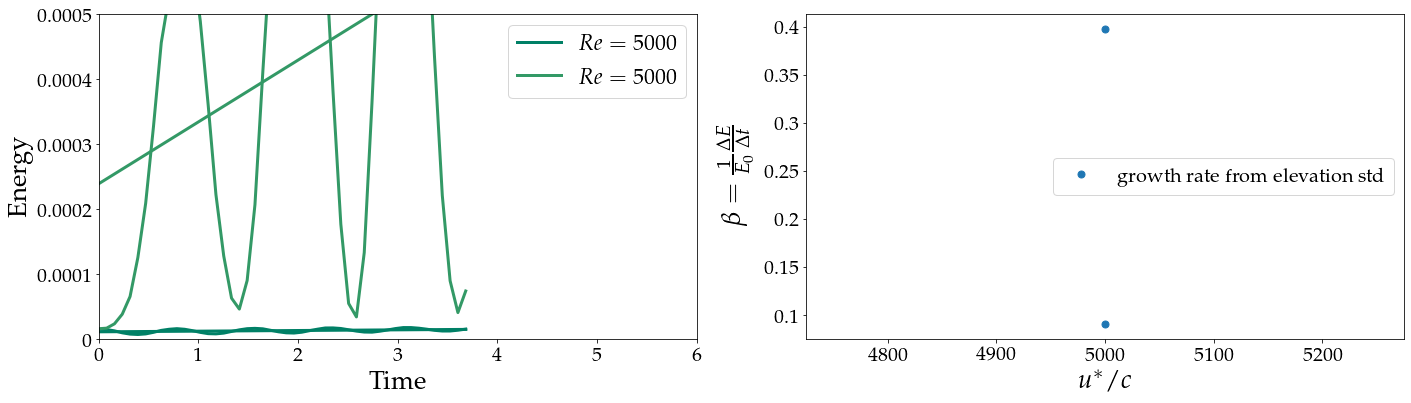

In [290]:
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
# Fit a linear growth to the lines
para_tag = np.char.mod('%d', para_pair_set[0])
# Time was scaled!!!
time = postfix_index * (2*np.pi)**0.5

Re = []
period = []
slope_std = []
slope_direct = []
slope_directdiss = []
beta_std = []
beta_direct = []
beta_directdiss = []
nondim_beta_std = []

def plot(ampl_subset, para_pair_subset, edirect_subset):
    ustar = []
    slope_std = []
    slope_direct = []
    slope_directdiss = []
    beta_std = []
    beta_direct = []
    beta_directdiss = []
    for i, (amplitude, para, energy) in enumerate(zip(ampl_subset, para_pair_subset, edirect_subset)):
        y = [ampl.stdev**2/2 for ampl in amplitude]
        a, b = np.polyfit(time, y, 1)
        c, d = np.polyfit(energy[energy.t<20].t, energy[energy.t<20].gpe+energy[energy.t<20].ke/2, 1) # kinetic energy was multiplied by 2
        e, f = np.polyfit(energy[energy.t<20].t, energy[energy.t<20].total_diss, 1)
        slope_std.append(a)
        slope_direct.append(c)
        slope_directdiss.append(e)
        beta_std.append(a/b)
        beta_direct.append(c/(energy.iloc[10].gpe+energy.iloc[10].ke/2))  # Take not exactly the first points
        beta_directdiss.append(c/energy.iloc[10].total_diss)
        Re.append(para[3])
        ax1.plot(time, [ampl.stdev**2/2 for ampl in amplitude], color=plt.cm.get_cmap('summer')(i*0.2))
        ax1.plot(time, a*time+b, label = r'$Re = %g$' %para[3], 
                 color=plt.cm.get_cmap('summer')(i*0.2))
    #     ax1.plot(energy.t, energy.total_diss, color=plt.cm.get_cmap('summer')(i*0.2))
    ax1.legend(fontsize = 22)
    ax1.set_ylim([0, 0.0005])
    ax1.set_xlim([0, 6])
    ax1.set_xlabel('Time', fontsize = 26)
    ax1.set_ylabel('Energy', fontsize = 26)
    ax2.plot(Re, np.array(beta_std), '.', markersize=14, label = 'growth rate from elevation std')
#     a, b = np.polyfit(np.log(np.array(ustar)), np.log(np.array(beta_std)), 1)
#     line, = ax2.plot(Re, np.exp(b)*np.array(ustar)**a)
    line.set_label(r'$\beta = %1.1f\cdot(u^*/c)^{%1.1f}$' %(np.exp(b),a))
    ax2.set_xlabel(r'$u^{*}/c$', fontsize = 26)
    ax2.set_ylabel(r'$\beta = \frac{1}{E_{0}}\frac{\Delta E}{\Delta t}$', fontsize = 26)
    ax2.legend(fontsize = 20)
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    fig.tight_layout()

ilist = np.arange(0,2)
ampl_subset = list(ampl_set[i] for i in ilist)  
para_pair_subset = list(para_pair_set[i] for i in ilist)
edirect_subset = list(edirect_set[i] for i in ilist)
plot(ampl_subset, para_pair_subset, edirect_subset)

In [ ]:
fig = plt.figure(figsize = (10, 6))

ax2 = fig.gca()
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax2.tick_params(axis='both', which='major', labelsize=14)
# Fit a linear growth to the lines
para_tag = np.char.mod('%d', para_pair_set[0])
# Time was scaled!!!
time = postfix_index * (2*np.pi)**0.5
Bo = []
period = []
slope_std = []
beta_std = []
ampl_subset = list(ampl_set[i] for i in [0,1,2,3,4,5])  #16,15,2,13,14
para_pair_subset = list(para_pair_set[i] for i in [0,1,2,3,4,5])
edirect_subset = list(edirect_set[i] for i in [0,1,2,3,4,5])
for i, (amplitude, para, energy) in enumerate(zip(ampl_subset, para_pair_subset, edirect_subset)):
    y = [ampl.stdev**2/2 for ampl in amplitude]
    a, b = np.polyfit(time, y, 1)
    slope_std.append(a)
    beta_std.append(a/y[0])
    Bo.append(para[2])
    period.append((2*np.pi)**0.5/(1+1/para[2])**0.5)
# ax1.yaxis.set_label_coords(-0.1,0.9)
# ax2.plot(Bo, np.array(beta_std)*np.array(period)/(2*np.pi), '.', markersize=14, label = 'growth rate from elevation std')
# ax2.plot(Bo, np.array(beta_direct)*np.array(period)/(2*np.pi), '.', markersize=14, label = 'direct output total energy')
# ax2.plot(Bo, np.array(beta_directdiss)*np.array(period)/(2*np.pi), '.', markersize=14, label = 'growth rate with dissipation')
ax2.plot(Bo, np.array(beta_std), '.', markersize=14, label = 'u* = 0.440')
# ax2.plot(Bo, np.array(beta_direct), '.', markersize=14, label = 'direct output total energy')
# ax2.plot(Bo, np.array(beta_directdiss), '.', markersize=14, label = 'growth rate with dissipation')
ax2.set_xlabel(r'$Bo$', fontsize = 26)
ax2.set_ylabel(r'$\beta = \frac{1}{E_{0}}\frac{\Delta E}{\Delta t}$', fontsize = 26)
ax2.legend(fontsize = 20)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    
Bo = []
period = []
slope_std = []
beta_std = []
ampl_subset = list(ampl_set[i] for i in [6,7,8,9,10,11])  #16,15,2,13,14
para_pair_subset = list(para_pair_set[i] for i in [6,7,8,9,10,11])
edirect_subset = list(edirect_set[i] for i in [6,7,8,9,10,11])
for i, (amplitude, para, energy) in enumerate(zip(ampl_subset, para_pair_subset, edirect_subset)):
    y = [ampl.stdev**2/2 for ampl in amplitude]
    a, b = np.polyfit(time, y, 1)
    slope_std.append(a)
    beta_std.append(a/y[0])
    Bo.append(para[2])
    period.append((2*np.pi)**0.5/(1+1/para[2])**0.5)

ax2.plot(Bo, np.array(beta_std), '.', markersize=14, label = 'u* = 0.484')
ax2.set_xlabel(r'$Bo$', fontsize = 26)
ax2.set_ylabel(r'$\beta = \frac{1}{E_{0}}\frac{\Delta E}{\Delta t}$', fontsize = 26)
ax2.legend(fontsize = 20)

Bo = []
period = []
slope_std = []
beta_std = []
ampl_subset = list(ampl_set[i] for i in [12,13,14,15,16,17])  #16,15,2,13,14
para_pair_subset = list(para_pair_set[i] for i in [12,13,14,15,16,17])
edirect_subset = list(edirect_set[i] for i in [12,13,14,15,16,17])
for i, (amplitude, para, energy) in enumerate(zip(ampl_subset, para_pair_subset, edirect_subset)):
    y = [ampl.stdev**2/2 for ampl in amplitude]
    a, b = np.polyfit(time, y, 1)
    c, d = np.polyfit(energy[energy.t<20].t, energy[energy.t<20].gpe+energy[energy.t<20].ke/2, 1) # kinetic energy was multiplied by 2
    e, f = np.polyfit(energy[energy.t<20].t, energy[energy.t<20].total_diss, 1)
    slope_std.append(a)
    beta_std.append(a/y[0])
    Bo.append(para[2])
    period.append((2*np.pi)**0.5/(1+1/para[2])**0.5)

ax2.plot(Bo, np.array(beta_std), '.', markersize=14, label = 'u* = 0.528')
ax2.set_xlabel(r'$Bo$', fontsize = 26)
ax2.set_ylabel(r'$\beta = \frac{1}{E_{0}}\frac{\Delta E}{\Delta t}$', fontsize = 26)
ax2.legend(fontsize = 20)

ax2.set_title("Growth rate from std", fontsize=24)

Bo = []
period = []
slope_std = []
beta_std = []
ampl_subset = list(ampl_set[i] for i in [18,19,20,21,22])  #16,15,2,13,14
para_pair_subset = list(para_pair_set[i] for i in [18,19,20,21,22])
edirect_subset = list(edirect_set[i] for i in [18,19,20,21,22])
for i, (amplitude, para, energy) in enumerate(zip(ampl_subset, para_pair_subset, edirect_subset)):
    y = [ampl.stdev**2/2 for ampl in amplitude]
    a, b = np.polyfit(time, y, 1)
    slope_std.append(a)
    beta_std.append(a/y[0])
    Bo.append(para[2])
    period.append((2*np.pi)**0.5/(1+1/para[2])**0.5)

ax2.plot(Bo, np.array(beta_std), '.', markersize=14, label = 'u* = 0.616')
ax2.set_xlabel(r'$Bo$', fontsize = 26)
ax2.set_ylabel(r'$\beta = \frac{1}{E_{0}}\frac{\Delta E}{\Delta t}$', fontsize = 26)
ax2.legend(fontsize = 20)

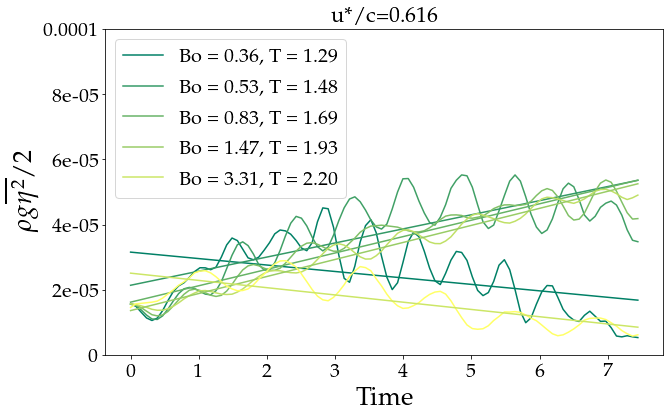

In [167]:
fig = plt.figure(figsize = (10, 6))
ax1 = fig.gca()
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax1.tick_params(axis='both', which='major', labelsize=14)
# Time was scaled!!!
time = postfix_index * (2*np.pi)**0.5
Bo = []
period = []
slope_std = []
beta_std = []
i_set = np.arange(18, 23)
ampl_subset = list(ampl_set[i] for i in i_set)  #16,15,2,13,14
para_pair_subset = list(para_pair_set[i] for i in i_set)
edirect_subset = list(edirect_set[i] for i in i_set)

size = len(postfix_index)
for ampl in ampl_subset:
    if size > len(ampl):
        size = len(ampl)
time = postfix_index[:size] * (2*np.pi)**0.5

for i, (amplitude, para, energy) in enumerate(zip(ampl_subset, para_pair_subset, edirect_subset)):
    y = [ampl.stdev**2/2 for ampl in amplitude]
    a, b = np.polyfit(time, y, 1)
    c, d = np.polyfit(energy[energy.t<20].t, energy[energy.t<20].gpe+energy[energy.t<20].ke/2, 1) # kinetic energy was multiplied by 2
    e, f = np.polyfit(energy[energy.t<20].t, energy[energy.t<20].total_diss, 1)
    slope_std.append(a)
    slope_direct.append(c)
    slope_directdiss.append(e)
    beta_std.append(a/y[0])
    beta_direct.append(c/(energy.iloc[10].gpe+energy.iloc[10].ke/2))  # Take not exactly the first points
    beta_directdiss.append(e/energy.iloc[10].total_diss)
    Bo.append(para[2])
    period.append((2*np.pi)**0.5/(1+1/para[2])**0.5)
    ax1.plot(time, [ampl.stdev**2/2 for ampl in amplitude], color=plt.cm.get_cmap('summer')(i*0.25))
    ax1.plot(time, a*time+b, label = 'Bo = %g, T = %1.2f' %(para[2],(2*np.pi)**0.5/(1+1/para[2])**0.5), 
             color=plt.cm.get_cmap('summer')(i*0.2))
#     ax1.plot(energy.t, energy.total_diss, color=plt.cm.get_cmap('summer')(i*0.2))
#     ax1.plot(energy.t * (2*np.pi)**0.5, energy.gpe+energy.ke/2, label = 'direct', color=plt.cm.get_cmap('summer')(i*0.2))
#     ax1.plot(time, c*time+d, color=plt.cm.get_cmap('summer')(i*0.2))
ax1.legend(fontsize=20, loc='upper left')
ax1.set_ylim([0, 0.0001])
ax1.set_xlabel('Time', fontsize = 26)
ax1.set_ylabel(r'$\rho g\overline{\eta^{2}}/2$', fontsize = 26)
ax1.set_title('u*/c=0.616', fontsize=22)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

In [96]:

def iter_check(dir_set, common_path, postfix_index, tag):
    amplitude_set = []
    energydirect_set = []
    for dirname in tqdm(dir_set):
        # Assemble the directory name corresponding to each parameter set
        # Example: dirname = './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10'
        os.chdir(common_path + dirname)
        # Call iter_onecase, pass directory name as a parameter
        amplitude, exists = iter_onecase(postfix_index_set=postfix_index, tag_set=tag, tag_common = 't = ')
        # If the file does not exceed, do not append
        if exists:
            amplitude_set.append(amplitude)
        energy, exists = readin('budgetWaterwind.dat', table_delimiter = ' ', skipn = 100)
        if exists:
            total = energy.ke + energy.gpe
            diss = np.zeros(energy.shape[0])
            for i, row in energy.iterrows():
                if i == 0:
                    diss[i] = 0
                    last_t = row['t'] # record t in last row
                else:
                    diss[i] = diss[i-1] + row['dissipation'] * (row['t'] - last_t)
                    last_t = row['t']
            energy.insert(len(energy.columns), "total", total, True)
            energy.insert(len(energy.columns), "total_diss", total+diss, True)
            energydirect_set.append(energy)       
    return amplitude_set, energydirect_set

common_path = '/home/jiarong/research/projects/windwave/'
dirname = ['linear_m8B0Ustar0.44ak0.05RE31000.LEVEL10_1nodes32cores', 'linear_m8B0Ustar0.44ak0.05RE31000.LEVEL10_1nodes40cores',
           'linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10', 'linear_m5B0Ustar0.44ak0.05Bo3.45Re31000.LEVEL10']
# dirname = ['linear_m8B0Ustar0.44ak0.05RE31000.LEVEL10_1nodes32cores', 'linear_m8B0Ustar0.44ak0.05RE31000.LEVEL10_1nodes40cores',
#            'linear_m8B0Ustar0.44ak0.05RE31000.LEVEL10_2nodes80cores', 'linear_m8B0Ustar0.44ak0.05RE31000.LEVEL10_4nodes160cores']
postfix_index = np.arange(0, 5, 0.03125)
tag = tag = np.char.mod('%d', postfix_index)
amplitude_set, energydirect_set = iter_check(dirname, common_path, postfix_index, tag)

100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


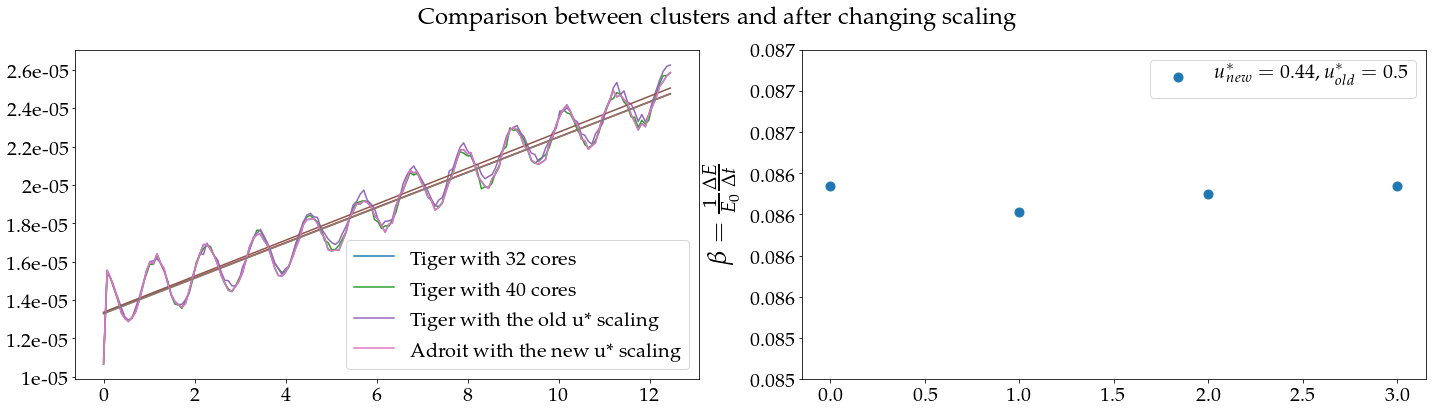

In [129]:
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

slope_std = []
beta_std = []
lines = []

time = postfix_index * (2*np.pi)**0.5
for i, (amplitude, energy) in enumerate(zip(amplitude_set, energydirect_set)):
    y = [ampl.stdev**2/2 for ampl in amplitude]
    a, b = np.polyfit(time, y, 1)
    slope_std.append(a)
    beta_std.append(a/y[0])
    line, = ax1.plot(time, [ampl.stdev**2/2 for ampl in amplitude])
    ax1.plot(time, a*time+b)
    lines.append(line)
lines[0].set_label(r'Tiger with 32 cores')
lines[1].set_label(r'Tiger with 40 cores')
lines[2].set_label(r'Tiger with the old u* scaling')
lines[3].set_label(r'Adroit with the new u* scaling')
ax1.legend(fontsize = 20)
line, = ax2.plot(np.array(beta_std), '.', markersize=18)
line.set_label(r'$u^*_{new}=0.44, u^*_{old}=0.5$')
ax2.set_ylim([0.085, 0.087])
ax2.set_ylabel(r'$\beta = \frac{1}{E_{0}}\frac{\Delta E}{\Delta t}$', fontsize = 26)
ax2.legend(fontsize = 20)
ax2.legend(fontsize = 20)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
fig.suptitle('Comparison between clusters and after changing scaling', fontsize = 24)
fig.tight_layout(rect=[0, 0.03, 1, 0.92])


In [54]:
time = postfix_index * (2*np.pi)**0.5
Bo = []
period = []
slope_std = []
slope_direct = []
slope_directdiss = []
beta_std = []
beta_direct = []
beta_directdiss = []
ampl_subset = list(ampl_set[i] for i in [40,41,42])  #16,15,2,13,14
para_pair_subset = list(para_pair_set[i] for i in [40,41,42])
edirect_subset = list(edirect_set[i] for i in [40,41,42])
for i, (amplitude, para, energy) in enumerate(zip(ampl_subset, para_pair_subset, edirect_subset)):
    y = [ampl.stdev**2/2 for ampl in amplitude]
    a, b = np.polyfit(time, y, 1)
    c, d = np.polyfit(energy[energy.t<20].t, energy[energy.t<20].gpe+energy[energy.t<20].ke/2, 1) # kinetic energy was multiplied by 2
    e, f = np.polyfit(energy[energy.t<20].t, energy[energy.t<20].total_diss, 1)
    slope_std.append(a)
    slope_direct.append(c)
    slope_directdiss.append(e)
    beta_std.append(a/y[0])
    beta_direct.append(c/(energy.iloc[10].gpe+energy.iloc[10].ke/2))  # Take not exactly the first points
    beta_directdiss.append(e/energy.iloc[10].total_diss)
    Bo.append(para[2])
    period.append((2*np.pi)**0.5/(1+1/para[2])**0.5)

1

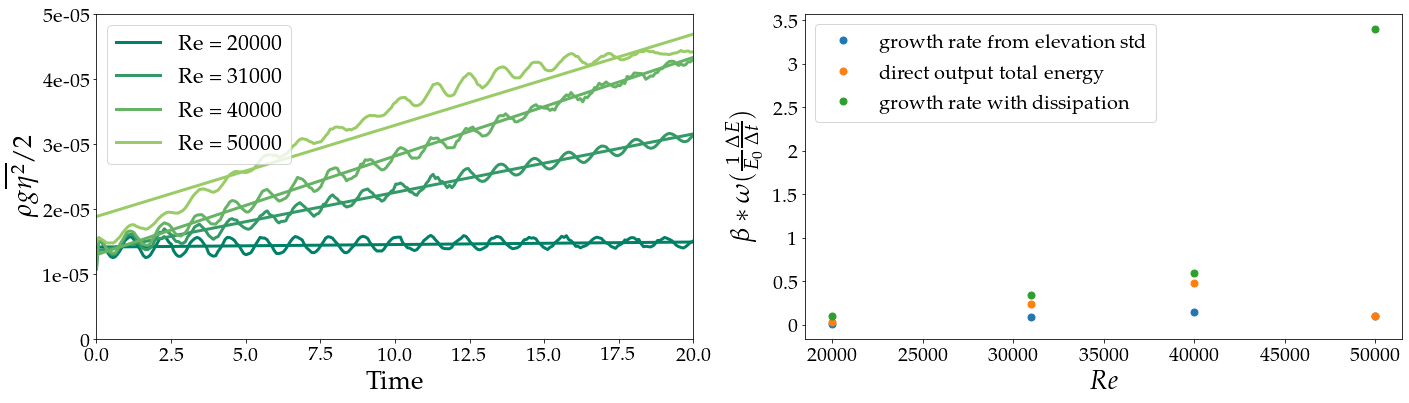

In [146]:
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
# Fit a linear growth to the lines
para_tag = np.char.mod('%d', para_pair_set[0])
# Time was scaled!!!
time = postfix_index * (2*np.pi)**0.5
Re = []
period = []
slope_std = []
slope_direct = []
slope_directdiss = []
beta_std = []
beta_direct = []
beta_directdiss = []
ampl_subset = list(ampl_set[i] for i in [17, 2, 18, 19])
para_pair_subset = list(para_pair_set[i] for i in [17, 2, 18, 19])
edirect_subset = list(edirect_set[i] for i in [17, 2, 18, 19])

for i, (amplitude, para, energy) in enumerate(zip(ampl_subset, para_pair_subset, edirect_subset)):
    y = [ampl.stdev**2/2 for ampl in amplitude]
    a, b = np.polyfit(time, y, 1)
    c, d = np.polyfit(energy[energy.t<20].t, energy[energy.t<20].gpe+energy[energy.t<20].ke/2, 1) # kinetic energy was multiplied by 2
    e, f = np.polyfit(energy[energy.t<20].t, energy[energy.t<20].total_diss, 1)
    slope_std.append(a)
    slope_direct.append(c)
    slope_directdiss.append(e)
    beta_std.append(a/y[0])
    beta_direct.append(c/(energy.iloc[10].gpe+energy.iloc[10].ke/2))  # Take not exactly the first points
    beta_directdiss.append(e/energy.iloc[10].total_diss)
    Re.append(para[3])
    period.append((2*np.pi)**0.5/(1+1/para[2])**0.5)
    ax1.plot(time, [ampl.stdev**2/2 for ampl in amplitude], color=plt.cm.get_cmap('summer')(i*0.2))
    ax1.plot(time, a*time+b, label = 'Re = %g' %para[3], 
             color=plt.cm.get_cmap('summer')(i*0.2))
#     ax1.plot(energy.t, energy.total_diss, color=plt.cm.get_cmap('summer')(i*0.2))
#     ax1.plot(energy.t * (2*np.pi)**0.5, energy.gpe+energy.ke/2, label = 'direct', color=plt.cm.get_cmap('summer')(i*0.2))
#     ax1.plot(time, c*time+d, color=plt.cm.get_cmap('summer')(i*0.2))
ax1.legend(fontsize = 22)
ax1.set_ylim([0, 0.00005])
ax1.set_xlim([0, 20])
ax1.set_xlabel('Time', fontsize = 26)
ax1.set_ylabel(r'$\rho g\overline{\eta^{2}}/2$', fontsize = 26)
# ax1.yaxis.set_label_coords(-0.1,0.9)
# ax2.plot(Bo, np.array(beta_std)*np.array(period)/(2*np.pi), '.', markersize=14, label = 'growth rate from elevation std')
# ax2.plot(Bo, np.array(beta_direct)*np.array(period)/(2*np.pi), '.', markersize=14, label = 'direct output total energy')
# ax2.plot(Bo, np.array(beta_directdiss)*np.array(period)/(2*np.pi), '.', markersize=14, label = 'growth rate with dissipation')
ax2.plot(Re, np.array(beta_std), '.', markersize=14, label = 'growth rate from elevation std')
ax2.plot(Re, np.array(beta_direct), '.', markersize=14, label = 'direct output total energy')
ax2.plot(Re, np.array(beta_directdiss), '.', markersize=14, label = 'growth rate with dissipation')
ax2.set_xlabel(r'$Re$', fontsize = 26)
ax2.set_ylabel(r'$\beta*\omega(\frac{1}{E_{0}}\frac{\Delta E}{\Delta t})$', fontsize = 26)
# ax2.set_ylim([-0.1, 0.4])
ax2.legend(fontsize = 20)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
fig.tight_layout()

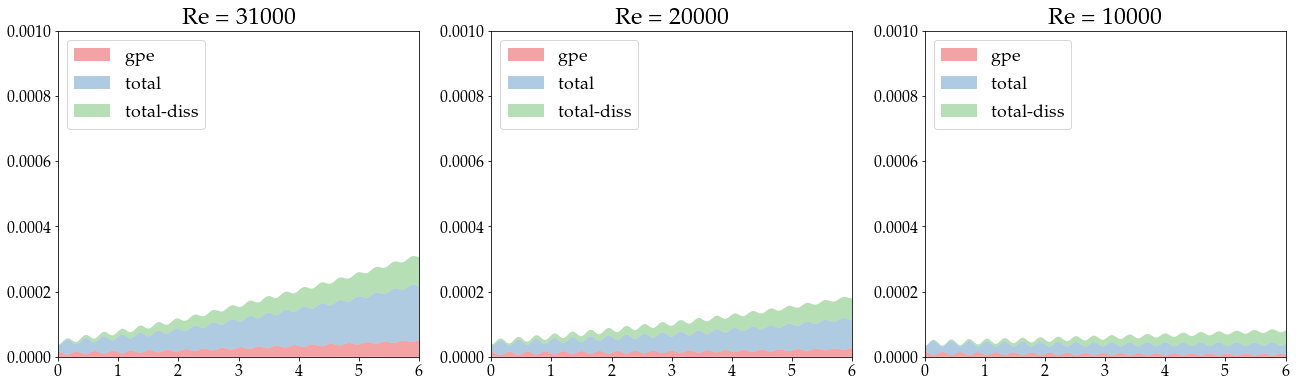

In [241]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Palatino']
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['axes.titlesize'] = 'xx-small'
plt.style.use('presentation')
import seaborn as sns
fig = plt.figure(figsize = (22, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
for i,ax,tag in zip([0,1,2], [ax1,ax2,ax3], [para_pair_set[0][3], para_pair_set[1][3], para_pair_set[2][3]]):
    x = edirect_set[i].t
    # xp = postfix_index * (2*np.pi)**0.5
    # fp = ampl_set[2].stdev**2/2
    # gpe = np.interp(x, xp, fp, left=None, right=None, period=None)
    y=[edirect_set[i].gpe, edirect_set[i].total-edirect_set[i].gpe, edirect_set[i].total_diss-edirect_set[i].total] 
    # use a known color palette (see..)
    pal = sns.color_palette("Set1")
    ax.stackplot(x,y,labels=['gpe', 'total', 'total-diss'], colors=pal, alpha=0.4)
    ax.legend(loc='upper left')
    ax.set_title('Re = %g' %tag)
    ax.set_xlim([0, 6])
    ax.set_ylim([0, 0.001])

In [249]:
4447*1.787/0.89

8928.976404494382

In [252]:
0.238*2*np.pi/500/0.89*10**6*(2*np.pi/(1+1/0.53))**0.5

4957.685442658743

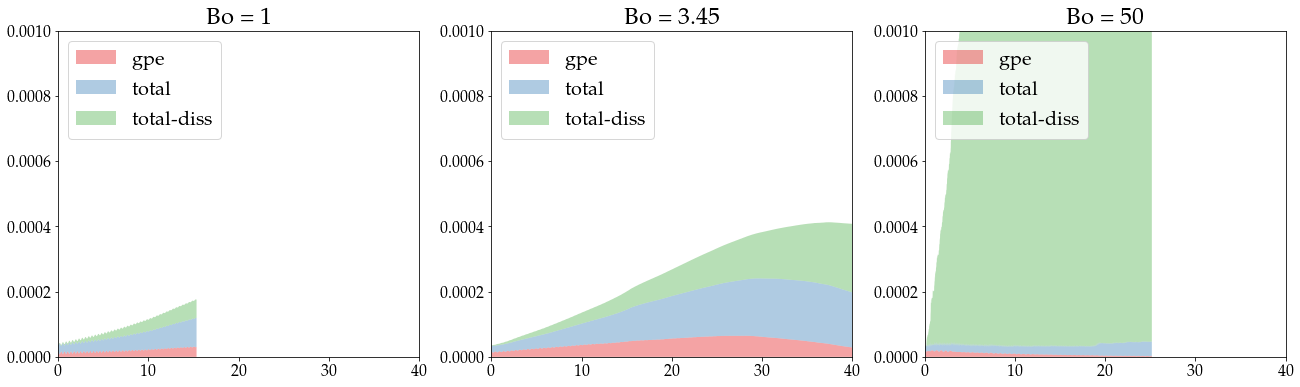

In [121]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Palatino']
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['axes.titlesize'] = 'xx-small'
plt.style.use('presentation')
import seaborn as sns
fig = plt.figure(figsize = (22, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
for i,ax,tag in zip([15, 2, 14], [ax1,ax2,ax3], [para_pair_set[15][2], para_pair_set[2][2], para_pair_set[14][2]]):
    x = edirect_set[i].t
    # xp = postfix_index * (2*np.pi)**0.5
    # fp = ampl_set[2].stdev**2/2
    # gpe = np.interp(x, xp, fp, left=None, right=None, period=None)
    y=[edirect_set[i].gpe, edirect_set[i].total-edirect_set[i].gpe, edirect_set[i].total_diss-edirect_set[i].total] 
    # use a known color palette (see..)
    pal = sns.color_palette("Set1")
    ax.stackplot(x,y,labels=['gpe', 'total', 'total-diss'], colors=pal, alpha=0.4)
    ax.legend(loc='upper left')
    ax.set_title('Bo = %g' %tag)
    ax.set_xlim([0, 40])
    ax.set_ylim([0, 0.001])


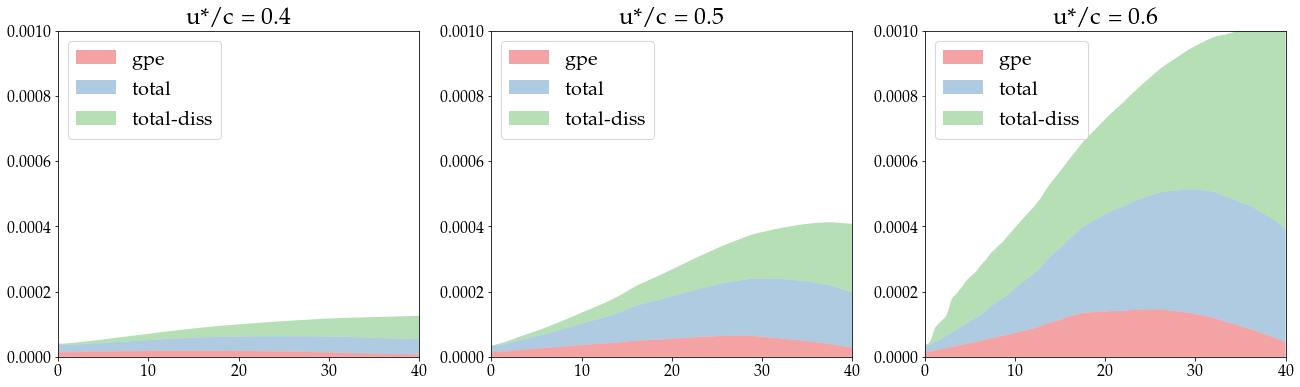

In [108]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Palatino']
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['axes.titlesize'] = 'xx-small'
plt.style.use('presentation')
import seaborn as sns
fig = plt.figure(figsize = (22, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
for i,ax,tag in zip([0,2,4], [ax1,ax2,ax3], [0.4, 0.5, 0.6]):
    x = edirect_set[i].t
    # xp = postfix_index * (2*np.pi)**0.5
    # fp = ampl_set[2].stdev**2/2
    # gpe = np.interp(x, xp, fp, left=None, right=None, period=None)
    y=[edirect_set[i].gpe, edirect_set[i].total-edirect_set[i].gpe, edirect_set[i].total_diss-edirect_set[i].total] 
    # use a known color palette (see..)
    pal = sns.color_palette("Set1")
    ax.stackplot(x,y,labels=['gpe', 'total', 'total-diss'], colors=pal, alpha=0.4)
    ax.legend(loc='upper left')
    ax.set_title('Bo = %g' %tag)
    ax.set_xlim([0, 40])
    ax.set_ylim([0, 0.001])

In [ ]:
plt.plot(ustar, beta_std, '.')
plt.plot(ustar, beta_std, '.')
plt.xscale('log')
plt.yscale('log')
a, b = np.polyfit(np.log(ustar[1:4]), np.log(beta_std[1:4]), 1)
plt.plot(ustar, np.exp(b)*np.array(ustar)**a)
print(a, b)

In [ ]:
for i in range(0,5):
    amplitude = ampl_set[i]
    para = para_pair_set[i]
    sdv = [ampl.stdev for ampl in amplitude]
    y = [ampl.stdev**2/2 for ampl in amplitude]
    a, b = np.polyfit(time, y, 1)
    omega = 2.85
    plt.plot(np.array(sdv)*(2*np.pi), np.array(a/y)/omega, label = 'u* = %g' %para[0])
plt.xlabel('Standard deviation of elevation * k', fontsize = 16)
plt.ylabel(r'$\beta /\omega (\delta E/ E\omega)$', fontsize = 16)
plt.legend()

In [ ]:
para_tag = np.char.mod('%d', para_pair_set)
# With lambda = 1 cases, k = 2pi, time is scaled as following
time = postfix_index * (2*np.pi)**0.5
a = [5, 6, 7, 8, 2, 9, 10, 11, 12]
N = len(a)
for i, (amplitude, para) in enumerate(zip([ampl_set[i] for i in a], [para_pair_set[i] for i in a])):
    plt.plot(time, [ampl.stdev**2/2 for ampl in amplitude], label = 'ak = %g' %para[1], color=plt.cm.get_cmap('summer')(i*1/N))
plt.xlim([0, 14])
plt.legend()

In [ ]:
fig = plt.figure(figsize = (18, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
# Fit a linear growth to the lines
para_tag = np.char.mod('%d', para_pair_set[0])
# Time was scaled!!!
time = postfix_index * (2*np.pi)**0.5
ak = []
slope_std = []
slope_direct = []
beta_std = []
beta_direct = []
a = [5, 6, 7, 8, 2, 9, 10]
N = len(a)
for i, (amplitude, para, energy) in enumerate(zip([ampl_set[i] for i in a], [para_pair_set[i] for i in a], 
                                                  [edirect_set[i] for i in a])):
    y = [ampl.stdev**2/2 for ampl in amplitude]
    a, b = np.polyfit(time, y, 1)
    c, d = np.polyfit(energy[energy.t<10].t, energy[energy.t<10].gpe+energy[energy.t<10].ke/2, 1)
    slope_std.append(a)
    slope_direct.append(c)
    beta_std.append(a/y[0])
    beta_direct.append(c/(energy.iloc[10].gpe+energy.iloc[10].ke))  # Take not exactly the first points
    ak.append(para[1])
    ax1.plot(time, [ampl.stdev**2/2 for ampl in amplitude], color=plt.cm.get_cmap('summer')(i*1/N))
    ax1.plot(time, a*time+b, label = 'ak = %g' %para[1] + r', $\beta$ = %1.2g' %a, 
             color=plt.cm.get_cmap('summer')(i*0.2))
ax1.legend(fontsize = 14)
ax1.set_xlim([0, 10])
ax1.set_xlabel('Time', fontsize = 16)
ax1.set_ylabel(r'$\rho g\overline{\eta^{2}}/2$', fontsize = 16)
# ax1.yaxis.set_label_coords(-0.1,0.9)
ax2.plot(ak, slope_std, '.', label = 'elevation std')
ax2.plot(ak, slope_direct, '.', label = 'elevation std')
ax2.set_xlabel('ak', fontsize = 16)
ax2.set_ylabel(r'$\beta (\Delta E/ \Delta t)$', fontsize = 16)
ax2.legend(fontsize = 14)

In [ ]:
plt.plot(ak, beta_std, '.', label = 'elevation std')
plt.plot(ak, beta_direct, '.', label = 'elevation std')

In [ ]:
for i in [6, 7, 8, 2, 9, 10]:
    amplitude = ampl_set[i]
    para = para_pair_set[i]
    sdv = [ampl.stdev for ampl in amplitude]
    y = [ampl.stdev**2/2 for ampl in amplitude]
    a, b = np.polyfit(time, y, 1)
    omega = 2.85
    plt.plot(np.array(sdv)*(2*np.pi), np.array(a/y)/omega, label = 'ak = %g' %para[1])
plt.xlabel('Standard deviation of elevation * k', fontsize = 16)
plt.ylabel(r'$\beta /\omega (\delta E/ E\omega)$', fontsize = 16)
plt.legend()

In [ ]:
from matplotlib import rc
from matplotlib.ticker import FormatStrFormatter
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('font', size=18)
rc('axes', titlesize=20)
para_pair_set = [(0.4,0.05,3.45,31000,10), (0.45,0.05,3.45,31000,10), (0.5,0.05,3.45,31000,10), (0.55,0.05,3.45,31000,10), 
                 (0.6,0.05,3.45,31000,10), (0.5,0.01,3.45,31000,11), (0.5,0.02,3.45,31000,10), (0.5,0.03,3.45,31000,10),
                 (0.5,0.04,3.45,31000,10), (0.5,0.06,3.45,31000,10), (0.5,0.1,3.45,31000,10), (0.5,0.15,3.45,31000,10),
                 (0.5,0.2,3.45,31000,10), (0.5,0.05,10,31000,10), (0.5,0.05,50,31000,10), (0.5,0.05,1,31000,10), 
                 (0.5,0.05,0.49,31000,10)]
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
a = [10]
time = postfix_index * (2*np.pi)**0.5
for (amplitude, para, energy) in zip([ampl_set[j] for j in a], [para_pair_set[j] for j in a], [edirect_set[j] for j in a]):
    energy = energy.sort_values(by = ['t'])
    ax.plot(time, [ampl.stdev**2/2 for ampl in amplitude], label = 'std of elevation')
    ax.plot(energy.t * (2*np.pi)**0.5, energy.gpe+energy.ke/2, label = 'direct total')
    ax.plot(energy.t * (2*np.pi)**0.5, energy.gpe, label = 'direct gpe')
    ax.plot(energy.t * (2*np.pi)**0.5, energy.ke/2, label = 'direct ke')
    ax.set_title('Energy Growth, ak = %g' %para[1], fontsize = 20)
    ax.set_xlim([0, 20])
    ax.legend(fontsize = 14, loc='upper left')

ax.set_ylabel('Energy')
ax.set_xlabel('Time')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
fig.show()

In [ ]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=18)
rc('axes', titlesize=20)
fig = plt.figure()
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
a = [10]
time = postfix_index * (2*np.pi)**0.5
for (amplitude, para, energy) in zip([ampl_set[j] for j in a], [para_pair_set[j] for j in a], [edirect_set[j] for j in a]):
    energy = energy.sort_values(by = ['t'])
    ax.plot(time, [ampl.stdev**2/2 for ampl in amplitude], label = 'std of elevation')
    ax.plot(energy.t * (2*np.pi)**0.5, energy.gpe+energy.ke/2, label = 'direct')
    ax.plot(energy.t * (2*np.pi)**0.5, energy.gpe, label = 'direct gpe')
    ax.plot(energy.t * (2*np.pi)**0.5, energy.ke/2, label = 'direct ke')
    ax.set_title('ak = %g' %para[1], fontsize = 14)
    ax.set_xlim([0, 20])
    ax.legend(fontsize = 14, loc='upper left')

In [ ]:
# A check for equal partition in no wind case
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
e_nowind = readin("/home/jiarong/research/projects/windwave/linear_nowind_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat", 
                 table_delimiter = ' ')
ax1.plot(e_nowind.t, e_nowind.ke, '.', label = 'ke')
ax1.plot(e_nowind.t, e_nowind.gpe, '.', label = 'gpe')
ax1.plot(e_nowind.t, e_nowind.gpe+e_nowind.ke, '.', label = 'total')
ax1.set_xlim([0,3])
ax1.set_title("Mistakenly doubled ke")
e_nowind = readin("/home/jiarong/research/projects/windwave/linear_nowind_fix_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat", 
                 table_delimiter = ' ')
ax2.plot(e_nowind.t, e_nowind.ke, '.', label = 'ke')
ax2.plot(e_nowind.t, e_nowind.gpe, '.', label = 'gpe')
ax2.plot(e_nowind.t, e_nowind.gpe+e_nowind.ke, '.', label = 'total')
ax2.set_xlim([0,3])
ax2.set_title("Correction by a factor of 2")

plt.legend()

Energy __per area__ is $\frac{1}{2}\rho gA^2$  
Notice that if the domain is doubled, multiplying by 2 is need. Also potential energy needs to be re-normalized.

In [ ]:
from visualization import contour
grid = (4, 4)
fig1, ax1 = plt.subplots(ncols=grid[1], nrows=grid[0], figsize = [22,20])
ax = ax1.flatten()
for i in range(0,16):
    t = (i)*1
    field = readin('field_direct%g' %t)
    ux_f = field.f*field['u.x']
    field['ux_f'] = ux_f
    contour(field, ' omega_air', ax[i], fieldmax=0.15, fieldmin=-0.15)
    ax[i].set_title('t = %g' %t)
fig2, ax2 = plt.subplots(ncols=grid[1], nrows=grid[0], figsize = [22,20])
ax = ax2.flatten()
for i in range(0,16):
    t = (i+16)*1
    field = readin('field_direct%g' %t)
    ux_f = field.f*field['u.x']
    field['ux_f'] = ux_f
    contour(field, 'ux_f', ax[i], fieldmax=0.15, fieldmin=-0.15)
    ax[i].set_title('t = %g' %t)

In [ ]:
os.chdir('/home/jiarong/research/projects/windwave/linear_plane_test2_Ustar0.5Bo3.45Re31000.LEVEL10')

In [ ]:
para_pair_set = [(0.4,0.05,3.45,31000,10), (0.45,0.05,3.45,31000,10), (0.5,0.05,3.45,31000,10), (0.55,0.05,3.45,31000,10), 
                 (0.6,0.05,3.45,31000,10), (0.5,0.01,3.45,31000,11), (0.5,0.02,3.45,31000,10), (0.5,0.1,3.45,31000,10),
                 (0.5,0.15,3.45,31000,10), (0.5,0.2,3.45,31000,10)]
n = 6
# Plot the power spectrum
fig = plt.figure(figsize = (10,8))
ax_add = fig.add_subplot(211)
ax = fig.add_subplot(212)
# Need to test the FFT function and see if double the domain size changes anything
amplitude = ampl_set[n]
color_idx = np.linspace(0, 1, len(amplitude))
timetick = postfix_index * (2*np.pi)**0.5
time = []
k = []
power = []
cutoff = 8
for i, ampl in enumerate(amplitude):
    ampl.FFT()
    ampl.plot_spectrum(ax_add, cutoff = 8, label_choice = None, color_choice = plt.cm.get_cmap('summer')(color_idx[i]))
    k.extend(np.arange(0, cutoff))
    power.extend(abs(ampl.spectrum[1])[0:cutoff])
    time.extend(np.ones(cutoff)*timetick[i])  #  self.spectrum = (wavenumber, Y)   

from mpl_toolkits.axes_grid1 import make_axes_locatable    
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

grid_x, grid_y = np.mgrid[0:20:100j, 0:7:100j]
grid_target = griddata((time, k), power, (grid_x, grid_y), method='cubic')
img = ax.imshow(grid_target.T,cmap='Blues', origin='lower', extent=(0, 20, 0, 7))
colorbar(img)
ax_add.set_xlabel(r'$k/(2\pi/L_{0})$', fontsize = 16)  # Lo = \lambda. The way wavenumber is scaled.
ax_add.set_ylabel(r'Magnitude', fontsize = 16)
ax_add.set_ylim([0, 0.016])
ax.set_xlabel('Time', fontsize = 16)
ax.set_ylabel(r'$k/(2\pi/L_{0})$', fontsize = 16)
ax_add.set_title('ak = %g, ' %para_pair_set[n][1] + 'u*/c = %g' %para_pair_set[n][0], fontsize = 20)

In [ ]:
# Cross-cases comparison is realized by a iterator of higher level
# Variables are denoted with Meta
def iter_onecase(postfix_index_set, tag_set, tag_common):

In [ ]:
# Compare energy growth
from energy_func import energy_comparison
# Creating 2 subplots
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# List here that cases that needs to be compared and there distinct labels

# filename_set = ['./linear_m5B0Ustar0.5ak0.01Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
#                 './linear_m5B0Ustar0.5ak0.02Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
#                 './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
#                 './linear_m5B0Ustar0.5ak0.1Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
#                 './linear_m5B0Ustar0.5ak0.15Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
#                 './linear_m5B0Ustar0.5ak0.2Bo3.45Re31000.LEVEL10/budgetWaterwind.dat'
#                ]
filename_set = ['./linear_m5B0Ustar0.5ak0.01Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat'
               ]
label_set = ['ak = 0.01', 'ak = 0.02', 'ak = 0.05', 'ak = 0.1', 'ak = 0.15', 'ak = 0.2']
# energy = pd.read_table(filename_set[0], delimiter = ' ', error_bad_lines=False)
energy = energy_comparison(filename_set, label_set, ax1, ax2, smooth = 'YES', simp = 'NO')
# growth_rate_set = energy_comparison(filename_set, label_set, ax1, ax2,smooth = 'YES', simp = 'YES')

ax1.legend()
ax2.legend()
# Might want to change this
ax1.set_xlim([0, 40])
ax1.set_ylim([0.9, 40])
ax2.set_xlim([0, 40])
ax2.set_ylim([-0.1, 0.4])
plt.show()

In [ ]:
# Compare Ustar
from energy_func import energy_comparison
# Creating 2 subplots
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# List here that cases that needs to be compared and there distinct labels

filename_set = ['./linear_m5B0Ustar0.4ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.45ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.55ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.6ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat'
               ]
label_set = ['Ustar = 0.4', 'Ustar = 0.45', 'Ustar = 0.5', 'Ustar = 0.55', 'Ustar = 0.6']
# energy = pd.read_table(filename_set[0], delimiter = ' ', error_bad_lines=False)
energy = energy_comparison(filename_set, label_set, ax1, ax2,smooth = 'YES', simp = 'YES')
# growth_rate_set = energy_comparison(filename_set, label_set, ax1, ax2,smooth = 'YES', simp = 'YES')

ax1.legend()
ax2.legend()
# Might want to change this
ax1.set_xlim([0, 40])
ax1.set_ylim([0, 40])
ax2.set_xlim([0, 40])
ax2.set_ylim([-0.1, 0.4])
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10))
N = 6
M = 8
t = np.zeros(N)
color_idx = np.linspace(0, 1, N)
start = 0
for i in range(start, 41, M):
    t[(i-start)//M] = i
    filename = "./linear_m5B0Ustar0.5ak0.2Bo3.45Re31000.LEVEL10/eta%g" % t[(i-start)//M]
    exists = os.path.exists(filename)
    if not exists:
        damage = 1
        print('damaged!')
    if exists:
        interface = pd.read_table(filename, delimiter = ',')
        interface = interface.sort_values(by = ['x'])
        Fs = 2048;  # sampling rate
        Ts = 1.0/Fs; # sampling interval
        x = np.arange(-0.5,0.5,Ts) # space vector

        y = np.interp(x, interface.x, interface.pos)
        n = len(y) # length of the signal
        k = np.arange(n)
        T = n/Fs
        frq = k/T # two sides frequency range
        frq = frq[0:int(n/256)] # one side frequency range
        Y = np.fft.fft(y)/n # fft computing and normalization
        Y = Y[0:int(n/256)]
        
        ax[0].plot(x, y*2*3.14, label = 't = %.0f' %i, color=plt.cm.get_cmap('summer')(color_idx[(i-start)//M]))

#         t_smooth = t[0::20]
#         y_smooth = spline(t, y, t_smooth)
#         ax[0].plot(t_smooth, y_smooth, label = 't = %.0f' %(i/100), color=plt.cm.get_cmap('summer')(color_idx[i]))
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Amplitude')
        ax[0].legend()
        ax[1].plot(frq, abs(Y), label = 't = %.0f' %i, color=plt.cm.get_cmap('summer')(color_idx[(i-start)//M])) # plotting the spectrum
        ax[1].set_xlabel('Wavenumber')
        ax[1].set_ylabel('|Y(Wavenumber)|')
        ax[1].legend()
        fig.show()

In [ ]:
# Read data from direct output field, interpolate onto uniform script.
# This may take some time...
field = pd.read_table('./linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/field_direct40', delimiter = ',')
from mpl_toolkits.axes_grid1 import make_axes_locatable
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)
from scipy.interpolate import griddata
points = np.array([field.x, field.y])
grid_x, grid_y = np.mgrid[-0.5:0.5:100j, -0.5:0.5:100j]
grid_ux = griddata((field.x, field.y), field['u.x'], (grid_x, grid_y), method='cubic')
grid_uy = griddata((field.x, field.y), field['u.y'], (grid_x, grid_y), method='cubic')

In [ ]:
# Plot ux and uy of the whole domain
# Upper and lower limit can be twisted to show more clearly the details
fig, (ax1, ax2) = plt.subplots(ncols=2)
img1 = ax1.imshow(grid_ux.T, extent=(-0.5,0.5,-0.5,0.5), vmin=0, vmax=0.02, cmap='RdBu', origin='lower')
colorbar(img1)
img2 = ax2.imshow(grid_uy.T, extent=(-0.5,0.5,-0.5,0.5), cmap='RdBu', origin='lower')
colorbar(img2)
plt.tight_layout(h_pad=1)